In [ ]:
import kwant
import kwant.continuum
import scipy.sparse.linalg

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\hhsomek\Anaconda3\envs\kwant\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
a=1
hamiltonian = "k_x**2 + k_y**2 + V(x, y)"
template = kwant.continuum.discretize(hamiltonian,grid=a)

Lx=800
Ly=1


def chain(site):
    (x, y) = site.pos
    return (0 <= x < Lx and 0 <= y < Ly)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly)

syst = kwant.Builder()
syst.fill(template, chain, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(template, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

C:\Users\hhsomek\Anaconda3\envs\kwant\lib\site-packages\sympy\__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
C:\Users\hhsomek\Anaconda3\envs\kwant\lib\site-packages\sympy\__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [ ]:
d1=4
d2=4
V1=-0.1*1
V2=0.1*1

In [ ]:
def potential(d1,d2,V1,V2):
    xperiod=d1+d2
    def heaviside(d1,xmod,y):
        if xmod<d1:
            return V1
        else:
            return V2
    def super_lattice(x,y):
        if 0<= y <Ly:
            return heaviside(d1, (x)%xperiod,y)
    return super_lattice

params=dict(V=potential(d1,d2,V1,V2))

399.stepWall time: 8.4 s


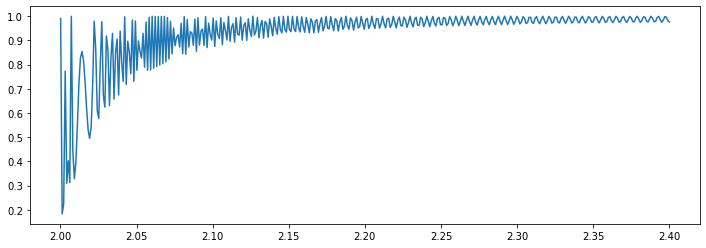

In [100]:
%%time
# Well-barrier
trans10 = []
NE=400
energy=np.linspace(2.0001,2.4001,NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission(0, 1))

plt.figure(figsize=(12,4))
plt.plot(energy,trans10)

999.stepWall time: 20 s


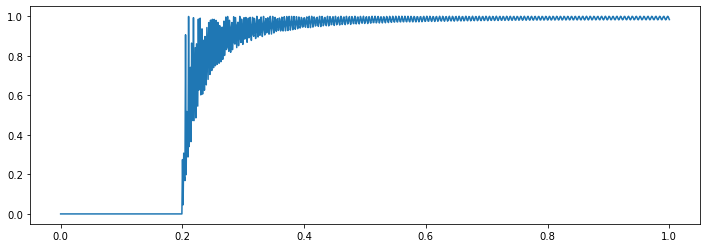

In [34]:
%%time
# Barrier-well
trans10 = []
NE=1000
energy=np.linspace(2.0001,3.0001,NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission(0, 1))

plt.figure(figsize=(12,4))
plt.plot(energy-2,trans10)

In [17]:
#np.savetxt('data/kwant_1D_normal_KP_cond_a={0}_b={1}_V0={2:.3f}_L={3}_NE={4}.txt'.format(a, b, V0, Lx, NE),[energy,trans10],fmt='%.18e')

In [ ]:
%%time
def lead_system(template):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(template, lead_shape, (0, 0))
    l_syst = lead.finalized()
    
    return l_syst

lead_syst=lead_system(template)

#band structure
bands = kwant.physics.Bands(lead_syst, params=params)
momenta = np.linspace(-np.pi, np.pi, 301)
energies = [bands(k) for k in momenta]

CPU times: total: 15.6 ms
Wall time: 26 ms


Text(0, 0.5, 'Energy')

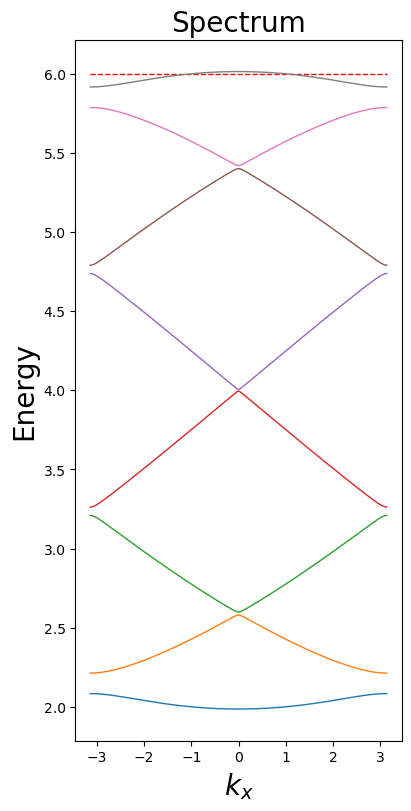

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=100, sharey=True, figsize=(4,4), constrained_layout=True)

ax.plot(momenta, 6.0*np.ones(len(momenta)),'r--',lw=1)

ax.plot(momenta, np.array(energies),'-',lw=1)
#ax.set_ylim(3,4)
ax.set_title('Spectrum',fontsize=20)
ax.set_xlabel('$k_x$', fontsize=20)
ax.set_ylabel('Energy', fontsize=20)

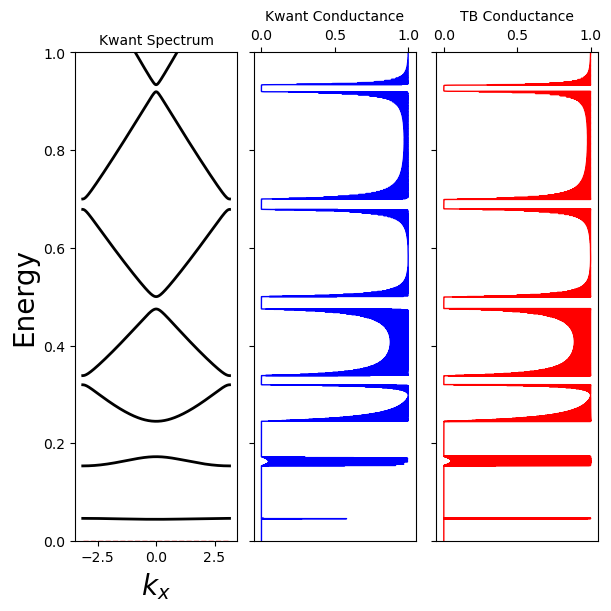

In [20]:
fig, ax = plt.subplots(1, 3, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)


ax[0].plot(momenta, np.zeros(len(momenta)),'r--',lw=1)

ax[0].plot(momenta, np.array(energies)-2, 'k',lw=2)
ax[0].set_title('Kwant Spectrum',fontsize=10)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
ax[0].set_ylim(-0.,1)

ax[1].plot(np.array(trans10),energy-2, 'b',lw=1)
ax[1].set_title('Kwant Conductance',fontsize=10)
ax[1].xaxis.set_ticks_position('top')

a=10 # Well width
b=10 # Barrier width
V0=0.2
NU=100
NEE=1000000
E,TN=np.loadtxt('data/bar_1D_TB_normal_KP_cond_a={0}_b={1}_V0={2:.3f}_NU={3}_NE={4}.txt'.format(a, b, V0, NU, NEE))

ax[2].plot(TN,E,'r-',lw=1)
ax[2].set_title('TB Conductance',fontsize=10)
ax[2].xaxis.set_ticks_position('top')

In [21]:
fig.savefig('figs/1D_TB_normal_spec_and_cond_L=2000.png')